In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import LabelEncoder
df=pd.read_csv("C:/Users/Manish/Desktop/Insurance Claim/data/merged_df")

df_imputed = df.copy()

# if 'report_delay_days' is missing, fill with 0
if "report_delay_days" in df_imputed.columns:
    df_imputed["report_delay_days"].fillna(0, inplace=True)

# 'premium' missing but 'sum_insured' is available then estimate 3% of sum insured
if "premium" in df_imputed.columns and "sum_insured" in df_imputed.columns:
    mask = df_imputed["premium"].isna() & df_imputed["sum_insured"].notna()
    df_imputed.loc[mask, "premium"] = df_imputed.loc[mask, "sum_insured"] * 0.03

for col in df_imputed.columns:
    if df_imputed[col].isnull().any():
        df_imputed[f"{col}_was_missing"] = df_imputed[col].isnull().astype(int)


num_cols = df_imputed.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_imputed.select_dtypes(include=["object", "category"]).columns.tolist()


if "is_fraud" in num_cols:
    num_cols.remove("is_fraud")


# KNN Imputation for numeric features
knn = KNNImputer(n_neighbors=5, weights="distance")
df_imputed[num_cols] = knn.fit_transform(df_imputed[num_cols])

# Mode Imputation for categorical features

for col in cat_cols:
    if df_imputed[col].isnull().any():
        mode_val = df_imputed[col].mode()[0]
        df_imputed[col].fillna(mode_val, inplace=True)


# 6️⃣ Encode Categorical Variables (Label Encoding)

le_map = {}
for col in cat_cols:
    le = LabelEncoder()
    df_imputed[col] = le.fit_transform(df_imputed[col].astype(str))
    le_map[col] = le

print(" Missing value imputation completed successfully!")



✅ Missing value imputation completed successfully!


In [ ]:
df=df_imputed

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_recall_curve,
    auc, precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt


base_features = [
    "claim_amount","sum_insured","premium","claim_to_sum_ratio","premium_to_sum_ratio",
    "report_delay_days","policy_age_at_incident","days_to_policy_end",
    "partner_degree","customer_degree","component_size","invoice_text_sim",
    "claim_vs_premium_ratio","claim_delay_ratio",
    "age","income","past_claims","loyalty_years"
]

features = [f for f in base_features if f in df.columns]
print("Using features:", features)

X = df[features].copy()
y = df["is_fraud"].astype(int).copy()

Using features: ['claim_amount', 'sum_insured', 'premium', 'claim_to_sum_ratio', 'premium_to_sum_ratio', 'report_delay_days', 'policy_age_at_incident', 'days_to_policy_end', 'partner_degree', 'customer_degree', 'component_size', 'invoice_text_sim', 'claim_vs_premium_ratio', 'claim_delay_ratio', 'age', 'income', 'past_claims', 'loyalty_years']


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Train fraud ratio:", y_train.mean(), "Test fraud ratio:", y_test.mean())

Train size: (4000, 18) Test size: (1000, 18)
Train fraud ratio: 0.09375 Test fraud ratio: 0.094


In [6]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, sampling_strategy=0.3)  # keep 30% minority class
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts(normalize=True))
print("After SMOTE:", y_train_res.value_counts(normalize=True))


Before SMOTE: 0    0.90625
1    0.09375
Name: is_fraud, dtype: float64
After SMOTE: 0    0.769312
1    0.230688
Name: is_fraud, dtype: float64


In [7]:
from sklearn.preprocessing import RobustScaler

num_cols = X_train_res.select_dtypes(include=['float64', 'int64']).columns
scaler = RobustScaler()

X_train_res[num_cols] = scaler.fit_transform(X_train_res[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [ ]:
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import numpy as np

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

for name, model in models.items():
    print(f"\n Model: {name}")
    model.fit(X_train_res, y_train_res)
    probs = model.predict_proba(X_test)[:, 1]
 # Precision-Recall tradeoff
    precisions, recalls, thresholds = precision_recall_curve(y_test, probs)
    fscore = (2 * precisions * recalls) / (precisions + recalls + 1e-6)
    best_idx = np.argmax(fscore)
    best_thresh = thresholds[best_idx]

    preds = (probs >= best_thresh).astype(int)

    print(f"Best Threshold: {best_thresh:.3f}")
    print(classification_report(y_test, preds, digits=3))
    print("ROC-AUC:", roc_auc_score(y_test, probs))



🔹 Model: Logistic Regression
Best Threshold: 0.588
              precision    recall  f1-score   support

           0      0.933     0.810     0.867       906
           1      0.192     0.436     0.267        94

    accuracy                          0.775      1000
   macro avg      0.563     0.623     0.567      1000
weighted avg      0.863     0.775     0.811      1000

ROC-AUC: 0.6814264243107416

🔹 Model: Random Forest
Best Threshold: 0.370
              precision    recall  f1-score   support

           0      0.933     0.976     0.954       906
           1      0.585     0.330     0.422        94

    accuracy                          0.915      1000
   macro avg      0.759     0.653     0.688      1000
weighted avg      0.901     0.915     0.904      1000

ROC-AUC: 0.6832170870320792

🔹 Model: Gradient Boosting
Best Threshold: 0.293
              precision    recall  f1-score   support

           0      0.934     0.972     0.953       906
           1      0.561     0.340

In [9]:
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import numpy as np

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

for name, model in models.items():
    print(f"\n🔹 Model: {name}")
    model.fit(X_train_res, y_train_res)
    probs = model.predict_proba(X_test)[:, 1]

    # Precision-Recall tradeoff
    precisions, recalls, thresholds = precision_recall_curve(y_test, probs)
    fscore = (2 * precisions * recalls) / (precisions + recalls + 1e-6)
    best_idx = np.argmax(fscore)
    best_thresh = thresholds[best_idx]

    preds = (probs >= best_thresh).astype(int)

    print(f"Best Threshold: {best_thresh:.3f}")
    print(classification_report(y_test, preds, digits=3))
    print("ROC-AUC:", roc_auc_score(y_test, probs))



🔹 Model: Logistic Regression
Best Threshold: 0.588
              precision    recall  f1-score   support

           0      0.933     0.810     0.867       906
           1      0.192     0.436     0.267        94

    accuracy                          0.775      1000
   macro avg      0.563     0.623     0.567      1000
weighted avg      0.863     0.775     0.811      1000

ROC-AUC: 0.6814264243107416

🔹 Model: Random Forest
Best Threshold: 0.370
              precision    recall  f1-score   support

           0      0.933     0.976     0.954       906
           1      0.585     0.330     0.422        94

    accuracy                          0.915      1000
   macro avg      0.759     0.653     0.688      1000
weighted avg      0.901     0.915     0.904      1000

ROC-AUC: 0.6832170870320792

🔹 Model: Gradient Boosting
Best Threshold: 0.293
              precision    recall  f1-score   support

           0      0.934     0.972     0.953       906
           1      0.561     0.340

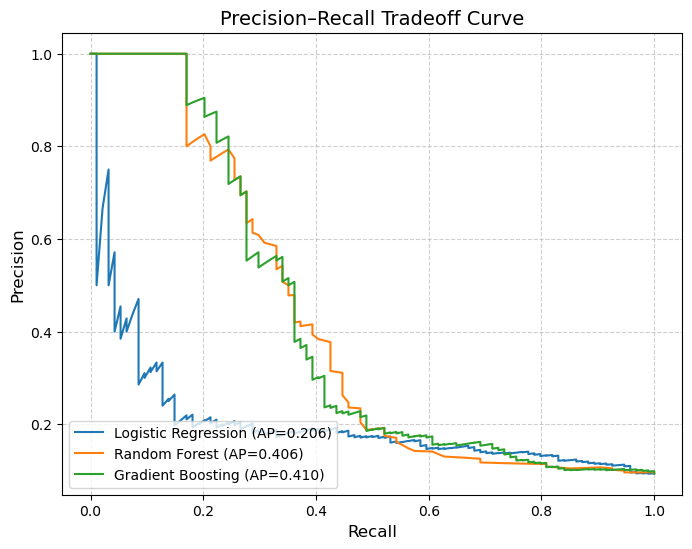

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8,6))

for name, model in models.items():
    # Get predicted probabilities
    probs = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, probs)
    ap = average_precision_score(y_test, probs)
    
    plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")

# Add chart details
plt.title("Precision–Recall Tradeoff Curve", fontsize=14)
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.legend(loc="lower left")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
